# Introduction
In `2. Part of Speech Tagging - LSTM` I attempted to use a RNN for Part of Speech (POS) tagging based on word embeddings created with Google's word2vec pretrained on their news data set, and some extra features.

In this notebook I will have another go at it with some more experience with RNNs. Also, this time I will be sure to ignore padded data when calculating loss functions by using the `sample_weight` parameter of `fit`. I think not suing sample weight might have severly harmed my previous model.

This time I will include a frozen embedding layer in my model instead of pre processing the data into word vectors.
I'll try word embeddings trained by [Glove](https://nlp.stanford.edu/projects/glove/) this time. Glove  which is Stanfords embedding model.

# The data
I will be using the same training data for my tagger as in `1. Part of Speech Tagging - First Atempt`:
[Universal Dependencies - English Web Treebank](http://universaldependencies.org/treebanks/en_ewt/index.html), a CoNLL-U formart corpus with 254 830 words and 16 622 sentences in english *taken from various web media including weblogs, newsgroups, emails, reviews, and Yahoo! answers*.

## Load the Data
First lets load the training data and convert it to a python dictionary and a pandas data frame.
I use the [conllu](https://github.com/EmilStenstrom/conllu) python package to parse the CoNLL-U files to dictionaries.

In [1]:
import numpy as np
import pandas as pd
import conllu

Read the data.

In [2]:
directory = 'UD/UD_English-EWT'
with open('{}/en_ewt-ud-train.conllu'.format(directory), 'r', encoding='utf-8') as f:
    train_text = f.read()
    
directory = 'UD/UD_English-EWT'
with open('{}/en_ewt-ud-dev.conllu'.format(directory), 'r', encoding='utf-8') as f:
    dev_text = f.read()
    
directory = 'UD/UD_English-EWT'
with open('{}/en_ewt-ud-test.conllu'.format(directory), 'r', encoding='utf-8') as f:
    test_text = f.read()

Convert it to a dictionary.

In [3]:
train_dict = conllu.parse(train_text)
dev_dict = conllu.parse(dev_text)
test_dict = conllu.parse(test_text)

Count sentences and tokens.

In [4]:
from functools import reduce

n_train_sentences = len(train_dict)
n_train_tokens = reduce(lambda x, y: x + len(y), train_dict, 0)

print("The training set contains {} sentences and {} tokens".format(n_train_sentences, n_train_tokens))

The training set contains 12543 sentences and 204607 tokens


In [5]:
train_sentences = [[token['form'] for token in sentence] for sentence in train_dict]
train_labels = [[token['upostag'] for token in sentence] for sentence in train_dict]

dev_sentences = [[token['form'] for token in sentence] for sentence in dev_dict]
dev_labels = [[token['upostag'] for token in sentence] for sentence in dev_dict]

test_sentences = [[token['form'] for token in sentence] for sentence in test_dict]
test_labels = [[token['upostag'] for token in sentence] for sentence in test_dict]

In [6]:
pos_tags = list(set(reduce(lambda x, y: x + y, train_labels)))

In [7]:
n_labels = len(pos_tags)
n_labels

17

In [8]:
pos_idx = dict(zip(pos_tags, np.arange(len(pos_tags))))

In [9]:
pos_encoding = {}
for pos, i in pos_idx.items():
    pos_encoding[pos] = np.zeros(len(pos_tags))
    pos_encoding[pos][i]=1

# Feature Engineering
[Wang et al.](https://arxiv.org/pdf/1510.06168.pdf) showed that a bidirectional LSTM network could achieve state of the art performance without using any morphological features, they only used these features:
* Word embedding of the word (cast to lower case)
* Suffix of length two, one-hot encoded
* Wether the word is all caps, lower case, or has an initial capital letter. One-hot encoded.

I am not using a bidirectional LSTM, but at least I am using a RNN. 
I'll opt to only use word embeddings for starters.

## Glove
I will opt to use the 100 dimensional Glove 6B data. My vocabulary will be exactly the words inside the pretrained model.

In [84]:
glove_path = 'glove/glove.6B/glove.6B.100d.txt'
embeddings = {}
token_index = {}
index_token = {}
with open(glove_path, 'r', encoding='utf-8') as f:
    for i, line in enumerate(f):
        tok, *vec = line.split()
        embeddings[tok] = np.array(vec, dtype='float32')
        # Reserve index 0 for padding
        token_index[tok] = i + 1
        index_token[i+1] = tok

Let's check if we have any words that are out of vocabulary OOV.

In [11]:
oov = []
for sentence in train_sentences:
    for tok in sentence:
        if tok not in embeddings:
            oov.append(tok)

In [12]:
len(oov)

31192

Ouch, 31 000 tokens out of 204 000 tokens are OOV. Most likely it's caused by what preprocessing was used.

In [13]:
oov[:10]

['Al',
 'Zaman',
 'American',
 'Shaikh',
 'Abdullah',
 'Ani',
 'Qaim',
 'Syrian',
 'This',
 'DPA']

Aha! Glove is only lower case, I should convert my data to lower case as well.

In [14]:
train_sentences = [[token.lower() for token in sentence] for sentence in train_sentences]
dev_sentences = [[token.lower() for token in sentence] for sentence in dev_sentences]
test_sentences = [[token.lower() for token in sentence] for sentence in test_sentences]

In [15]:
oov = []
for sentence in train_sentences:
    for tok in sentence:
        if tok not in embeddings:
            oov.append(tok)

In [16]:
len(oov)

2442

Down to 2 442 OOV tokens!

In [17]:
oov[:100]

["'akkab",
 'jubur',
 'batawi',
 'sarhid',
 'batawi',
 'clientelage',
 "47's",
 'fallujan',
 'saddamites',
 'fallujan',
 'sweared',
 'unscear',
 'conseguences',
 'emercom',
 'wi940',
 'http://www.ibiblio.org/expo/soviet.exhibit/chernobyl.html',
 'http://www.ibrae.ac.ru/ibrae/eng/chernobyl/nat_rep/nat_repe.htm#24',
 'http://www.nsrl.ttu.edu/chernobyl/wildlifepreserve.htm',
 'http://www.environmentalchemistry.com/yogi/hazmat/articles/chernobyl1.html',
 'http://digon_va.tripod.com/chernobyl.htm',
 'http://www.oneworld.org/index_oc/issue196/byckau.html',
 'http://www.collectinghistory.net/chernobyl/',
 'http://www.ukrainianweb.com/chernobyl_ukraine.htm',
 'http://www.bullatomsci.org/issues/1993/s93/s93marples.html',
 'http://www.calguard.ca.gov/ia/chernobyl-15%20years.htm',
 'http://www.infoukes.com/history/chornobyl/gregorovich/index.html',
 'http://www.un.org/ha/chernobyl/',
 'http://www.tecsoc.org/pubs/history/2002/apr26.htm',
 'http://www.chernobyl.org.uk/page2.htm',
 'http://www.time.

Lot's of Arabic sounding words, urls and misspelled words. Let's see if the gensim data has an url token.

In [18]:
'url' in embeddings

True

Cool, let's replace all urls with that one. Also, let's check what POS tags are expected for urls.

In [19]:
import re

In [20]:
def process_word(word):
    # Match words starting with www., http:// or https://
    if re.match(r'^(?:https{0,1}\:\/\/.*|www\.*)', word):
        return "url"
    else:
        return word.lower()

In [21]:
train_sentences = [[process_word(word) for word in sentence] for sentence in train_sentences]
dev_sentences = [[process_word(word) for word in sentence] for sentence in dev_sentences]
test_sentences = [[process_word(word) for word in sentence] for sentence in test_sentences]

In [22]:
oov = []
for sentence in train_sentences:
    for tok in sentence:
        if tok not in embeddings:
            oov.append(tok)

In [23]:
len(oov)

2310

In [24]:
url_tags = []
for i, sentence in enumerate(train_sentences):
    for j, tok in enumerate(sentence):
        if tok == 'url':
            url_tags.append(train_labels[i][j])

In [25]:
np.unique(np.array(url_tags),return_counts=True)

(array(['NOUN', 'PROPN', 'X'],
       dtype='<U5'), array([  2,   1, 132], dtype=int64))

Most are classified as `X`. I think casting them all to `url` is sound!

It would be interesting to correct the spelling of all misspelled words. One method could be to calculate the [Damerau–Levenshtein distance](https://en.wikipedia.org/wiki/Damerau%E2%80%93Levenshtein_distance) of all OOV words to words inside the vocabulary, and casting them to the closest match (if it is withing some maxmimum distance).

[Norvig](http://norvig.com/spell-correct.html) shows how to find all words within 2 Damerau-Levenshtein distance. Neat!
THis method is easily extended to find all words within k.

First, find all characters present in the embeddings.

In [26]:
character_vocab = set()

for word in embeddings:
    for c in word:
        character_vocab.add(c)

In [27]:
len(character_vocab)

489

Ouch, that's a lot of characters. Lets ignore all characters that are not ascii. (I think these characters are the most common in misspellings.)

In [28]:
# Only keep characters in the ascii range
ascii_vocab = set([c for c in character_vocab if 32 <= ord(c) <= 126])

In [29]:
len(ascii_vocab)

68

In [30]:
def neighbour_words(word):
    # Tuples with all possible splits of word
    splits = [(word[:i], word[i:]) for i in range(len(word))]
    
    # All words generated by deleting one character
    deletes = [L + R[1:] for L, R in splits if R]
    # All words generated by swapping two characters in word
    transposes = [L + R[1] + R[0] + R[2:] for L, R in splits if len(R) > 1]
    # All words generated by inserting a character in word
    insertions = [L + c + R for L, R in splits for c in ascii_vocab]
    # All words generated by replacing a character in word
    replace = [L + c +R[1:] for L, R, in splits for c in ascii_vocab if R]
    
    return set(deletes+transposes+insertions+replace)
    

In [31]:
def fix_spelling(word, vocab, max_distance=1):
    candidates = set([word])
    
    for i in range(max_distance+1):
        for candidate in candidates:
            if candidate in vocab:
                return candidate
        new_candidates = set()
        for candidate in candidates:
            new_candidates = new_candidates.union(neighbour_words(candidate))
        candidates = new_candidates
    return None

Right, the amount of possibilities explode for longer words and this large vocabulary.
I'll only search for matches withing just one edit, and if there are many possibilities I don't care which one.

Here is a version of the above function that will just look at distance one, and return the first match.

In [32]:
def find_one_neighbour(word, vocab):
    # Tuples with all possible splits of word
    splits = [(word[:i], word[i:]) for i in range(len(word))]
    
    # All words generated by deleting one character
    for L, R in splits:
        candidate = L + R[1:] if R else None
        if candidate in vocab:
            return candidate
    # All words generated by swapping two characters in word
    for L, R in splits:
        candidate = L + R[1:] if R else None
        if candidate in vocab:
            return candidate
    # All words generated by swapping two characters in word
    for L, R in splits:    
        candidate = L + R[1] + R[0] + R[2:] if len(R) > 1 else None
        if candidate in vocab:
            return candidate
    # All words generated by inserting a character in word
    for L, R in splits:
        for c in ascii_vocab:    
            candidate = L + c + R 
            if candidate in vocab:
                return candidate
    # All words generated by replacing a character in word
    for L, R, in splits:
        for c in ascii_vocab:    
            candidate = L + c +R[1:] if R else None
            if candidate in vocab:
                return candidate
        
    return None
    

In [33]:
find_one_neighbour("mispeled", ["misspelled"])

In [34]:
fixed_spelling = [find_one_neighbour(word, embeddings) for word in oov]

In [35]:
new_spelling = dict(zip(oov, fixed_spelling))

In [36]:
list(new_spelling.items())[:20]

[("'akkab", None),
 ('jubur', 'subur'),
 ('batawi', 'tatawi'),
 ('sarhid', 'sahid'),
 ('clientelage', None),
 ("47's", '47s'),
 ('fallujan', 'falluja'),
 ('saddamites', None),
 ('sweared', 'seared'),
 ('unscear', None),
 ('conseguences', 'consequences'),
 ('emercom', None),
 ('wi940', None),
 ("50's", '50s'),
 ('hirsohima', 'hiroshima'),
 ('nagaski', 'nagasaki'),
 ('.......', None),
 ('wearies', 'wearier'),
 ('post-saddam', None),
 ('jawaharal', 'jawaharlal')]

In [37]:
n_fixed = len(oov) - np.asarray(fixed_spelling, dtype='bool').sum()

In [38]:
n_fixed

1066

Might not always be perfect corrections, but I think this is better than keeping the words as oov.

In [39]:
def replace_words(word, fix_dict):
    if word in fix_dict:
        return fix_dict[word]
    else:
        return word

In [40]:
def find_oov(sentences, vocab):
    oov = []
    for sentence in train_sentences:
        for tok in sentence:
            if tok not in embeddings:
                oov.append(tok)
    return oov

In [41]:
oov_train = find_oov(train_sentences, embeddings)
fixed_spelling_train = [find_one_neighbour(word, embeddings) for word in oov_train]
fixed_spelling_train = dict(zip(oov_train, fixed_spelling_train))

In [42]:
oov_dev = find_oov(dev_sentences, embeddings)
fixed_spelling_dev = [find_one_neighbour(word, embeddings) for word in oov_dev]
fixed_spelling_dev = dict(zip(oov_dev, fixed_spelling_dev))

In [43]:
oov_test = find_oov(test_sentences, embeddings)
fixed_spelling_test = [find_one_neighbour(word, embeddings) for word in oov_test]
fixed_spelling_test = dict(zip(oov_test, fixed_spelling_test))

In [44]:
train_sentences = [[replace_words(word, fixed_spelling_train) for word in sentence] for sentence in train_sentences]
dev_sentences = [[replace_words(word, fixed_spelling_dev) for word in sentence] for sentence in dev_sentences]
test_sentences = [[replace_words(word, fixed_spelling_test) for word in sentence] for sentence in test_sentences]

## Encoding the data
I will encode the targets and the tokens as integers.
Later I will encode targets with one-hot encoding.

### Labels
First build a map from pos tag to an index.

In [45]:
pos_tag_index = {}
for i, pos in enumerate(pos_tags):
    # Reserve 0 for padded labels
    pos_tag_index[pos] = i + 1

In [301]:
Y_train = np.asarray([np.asarray([pos_tag_index[pos] for pos in sentence]) for sentence in train_labels])
Y_dev = np.asarray([np.asarray([pos_tag_index[pos] for pos in sentence]) for sentence in dev_labels])
Y_test = np.asarray([np.asarray([pos_tag_index[pos] for pos in sentence]) for sentence in test_labels])

### Tokens
I already built the mapping from token to index.
Encode all OOV tokens as "unk". See https://stackoverflow.com/questions/49239941/what-is-unk-in-glove-6b-50d-txt

In [302]:
X_train = np.asarray([np.asarray([token_index[tok if tok in token_index else "unk"] for tok in sentence]) for sentence in train_sentences])
X_dev = np.asarray([np.asarray([token_index[tok if tok in token_index else "unk"]  for tok in sentence]) for sentence in dev_sentences])
X_test = np.asarray([np.asarray([token_index[tok if tok in token_index else "unk"] for tok in sentence]) for sentence in test_sentences])

## Pad the data

In [51]:
max_sentence_length = max([len(sentence) for sentence in train_sentences])

In [52]:
from keras.preprocessing.sequence import pad_sequences

Using TensorFlow backend.


In [53]:
X_train = pad_sequences(X_train, maxlen=max_sentence_length, padding='post')
Y_train = pad_sequences(Y_train, maxlen=max_sentence_length, padding='post')

In [54]:
X_dev = pad_sequences(X_dev, maxlen=max_sentence_length, padding='post')
Y_dev = pad_sequences(Y_dev, maxlen=max_sentence_length, padding='post')

In [55]:
X_test = pad_sequences(X_test, maxlen=max_sentence_length, padding='post')
Y_test = pad_sequences(Y_test, maxlen=max_sentence_length, padding='post')

### Set sample weights
We should not considered training instances with word index 0 when calculating our loss function, as these are padding.

In [59]:
sample_weights_train = (X_train != 0).reshape(X_train.shape[0], X_train.shape[1])
sample_weights_train = sample_weights_train.astype(int)

In [60]:
sample_weights_dev = (X_dev != 0).reshape(X_dev.shape[0], X_dev.shape[1])
sample_weights_dev = sample_weights_dev.astype(int)

In [61]:
sample_weights_test = (X_test != 0).reshape(X_test.shape[0], X_test.shape[1])
sample_weights_test = sample_weights_test.astype(int)

## One-hot Encode Labels

In [62]:
def one_hot(i, n):
    arr = np.zeros(n)
    arr[i] = 1
    return arr

In [63]:
Y_train[0]

array([10, 12, 10, 12,  3,  4, 13, 10, 10, 10, 12, 10, 12,  5,  4, 16,  5,
        4, 16,  5,  4, 16, 10, 12, 16,  5,  3,  4, 12,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0])

In [64]:
Y_train = np.asarray([np.asarray([one_hot(i, n_labels+1) for i in sentence]) for sentence in Y_train])

Y_dev = np.asarray([np.asarray([one_hot(i, n_labels+1) for i in sentence]) for sentence in Y_dev])

Y_test = np.asarray([np.asarray([one_hot(i, n_labels+1) for i in sentence]) for sentence in Y_test])

In [65]:
Y_train.shape

(12543, 159, 18)

# RNN

## Embedding Layer
Create a frozen embedding layer from the Glove data.

In [72]:
embedding_dims = 100

pad = np.zeros(embedding_dims).reshape(1, embedding_dims)

embedding_matrix = np.concatenate([pad, np.array(list(embeddings.values()))])

n_words = len(embedding_matrix)

In [95]:
from keras.layers import Embedding

In [96]:
embedding_layer = Embedding(n_words,
                            embedding_dims,
                            weights=[embedding_matrix],
                            input_length=max_sentence_length,
                            trainable=False)

## First Model

In [97]:
from keras.layers import GRU, Input, Dense, Dropout, BatchNormalization
from keras.models import Model

In [101]:
latent_dim = 256

In [217]:
model_input = Input(shape=(None,))
x = embedding_layer(model_input)
x = BatchNormalization()(x)
x = GRU(latent_dim, return_sequences=True)(x)
model_output = Dense(n_labels + 1, activation='softmax')(x)
model = Model(model_input, model_output)

I use the weighted_metrics argument instead of metrics because I don't want to include padding when calculating accuracy.

In [218]:
model.compile(optimizer='adam', loss='categorical_crossentropy', sample_weight_mode='temporal', weighted_metrics=['accuracy'])

In [219]:
from keras.callbacks import History 

In [220]:
callback = model.fit(X_train, Y_train,
          batch_size=64,
          epochs=5,
          sample_weight=sample_weights_train,
          validation_data=(X_dev, Y_dev, sample_weights_dev),
          callbacks = [History()])

Train on 12543 samples, validate on 2002 samples
Epoch 1/5
12543/12543 [==============================] - 330s 26ms/step - loss: 0.6036 - weighted_acc: 0.8208 - val_loss: 0.3917 - val_weighted_acc: 0.8839
Epoch 2/5
12543/12543 [==============================] - 338s 27ms/step - loss: 0.2848 - weighted_acc: 0.9125 - val_loss: 0.3273 - val_weighted_acc: 0.8984
Epoch 3/5
12543/12543 [==============================] - 336s 27ms/step - loss: 0.2234 - weighted_acc: 0.9301 - val_loss: 0.3063 - val_weighted_acc: 0.9052
Epoch 4/5
12543/12543 [==============================] - 340s 27ms/step - loss: 0.1873 - weighted_acc: 0.9409 - val_loss: 0.3065 - val_weighted_acc: 0.9067
Epoch 5/5
12543/12543 [==============================] - 359s 29ms/step - loss: 0.1592 - weighted_acc: 0.9497 - val_loss: 0.3021 - val_weighted_acc: 0.9091


In [234]:
history_df = pd.DataFrame(callback.history)
history_df.index = np.arange(1, history_df.shape[0]+1)

In [235]:
history_df

,loss,val_loss,val_weighted_acc,weighted_acc
1,0.603642,0.391734,0.883905,0.820780
2,0.284763,0.327256,0.898351,0.912548
3,0.223450,0.306300,0.905157,0.930096
4,0.187292,0.306545,0.906701,0.940925
5,0.159196,0.302063,0.909146,0.949655


In [228]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
%matplotlib inline

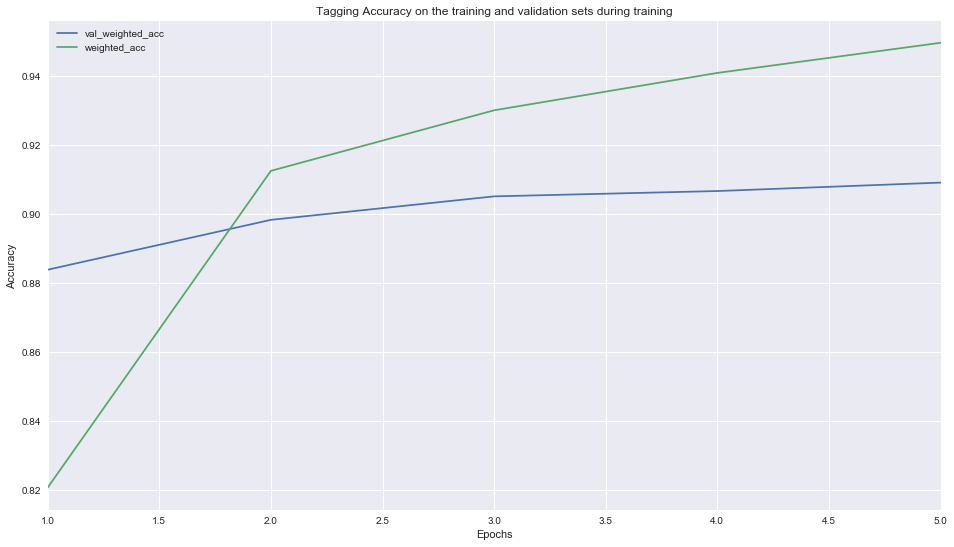

In [236]:
f, ax = plt.subplots(figsize=(16, 9))

history_df[['val_weighted_acc', 'weighted_acc']].plot(ax=ax)
ax.set_ylabel("Accuracy")
ax.set_xlabel('Epochs')
ax.set_title('Tagging Accuracy on the training and validation sets during training')


Validation accuracy almost reaches 91% in 5 epochs.
My previous best model was a DNN that reached 93% validation accuracy, maybe I can surpas this with enough training.

Unfortunately training accuracy is improving much quicker than validation accuracy, meaning the model is showing signs of overfitting.
Let's regularize it with Dropout.

In [239]:
model.save('keras_models/gru1_5_epochs.h5')

## Model Two, Dropout
Let's add dropout to the layers of the previous model.

In [240]:
from keras.layers import Dropout

In [241]:
model_input = Input(shape=(None,))
x = embedding_layer(model_input)
x = Dropout(rate=.5)(x)
x = BatchNormalization()(x)
x = GRU(latent_dim, return_sequences=True)(x)
x = Dropout(rate=.5)(x)
model_output = Dense(n_labels + 1, activation='softmax')(x)
model2 = Model(model_input, model_output)

I use the weighted_metrics argument instead of metrics because I don't want to include padding when calculating accuracy.

In [242]:
model2.compile(optimizer='adam', loss='categorical_crossentropy', sample_weight_mode='temporal', weighted_metrics=['accuracy'])

In [243]:
callback = model2.fit(X_train, Y_train,
          batch_size=64,
          epochs=5,
          sample_weight=sample_weights_train,
          validation_data=(X_dev, Y_dev, sample_weights_dev),
          callbacks = [History()])

Train on 12543 samples, validate on 2002 samples
Epoch 1/5
12543/12543 [==============================] - 291s 23ms/step - loss: 1.2682 - weighted_acc: 0.6028 - val_loss: 0.6200 - val_weighted_acc: 0.8071
Epoch 2/5
12543/12543 [==============================] - 326s 26ms/step - loss: 0.8398 - weighted_acc: 0.7259 - val_loss: 0.5331 - val_weighted_acc: 0.8357
Epoch 3/5
12543/12543 [==============================] - 352s 28ms/step - loss: 0.7481 - weighted_acc: 0.7544 - val_loss: 0.4978 - val_weighted_acc: 0.8453
Epoch 4/5
12543/12543 [==============================] - 359s 29ms/step - loss: 0.6981 - weighted_acc: 0.7707 - val_loss: 0.4697 - val_weighted_acc: 0.8547
Epoch 5/5
12543/12543 [==============================] - 363s 29ms/step - loss: 0.6623 - weighted_acc: 0.7827 - val_loss: 0.4498 - val_weighted_acc: 0.8625


In [244]:
history_df = pd.DataFrame(callback.history)
history_df.index = np.arange(1, history_df.shape[0]+1)

In [245]:
history_df

,loss,val_loss,val_weighted_acc,weighted_acc
1,1.268206,0.619999,0.807134,0.602827
2,0.839784,0.533110,0.835683,0.725871
3,0.748131,0.497780,0.845260,0.754424
4,0.698109,0.469708,0.854695,0.770725
5,0.662290,0.449781,0.862550,0.782689


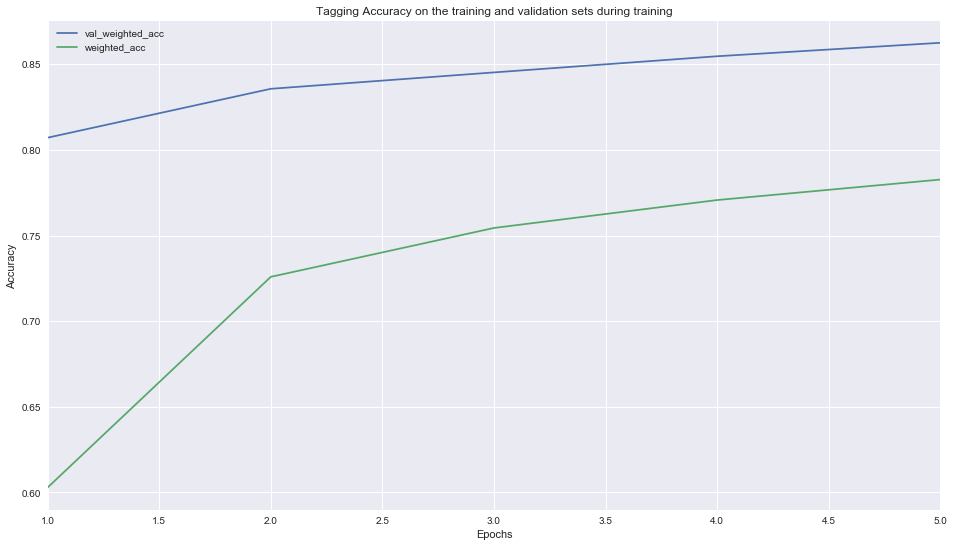

In [246]:
f, ax = plt.subplots(figsize=(16, 9))

history_df[['val_weighted_acc', 'weighted_acc']].plot(ax=ax)
ax.set_ylabel("Accuracy")
ax.set_xlabel('Epochs')
ax.set_title('Tagging Accuracy on the training and validation sets during training')


Here training accuracy is evaluated with dropout applied, leading to it always being subpar to the validation accuracy which is evaluated with the full RNN.

Validation accuracy is improving significantly with each step, though it starts much lower compared to the previous model.

In [248]:
model2.evaluate(X_train, Y_train, sample_weight=sample_weights_train)

12543/12543 [==============================] - 133s 11ms/step


[0.38856157256087021, 0.87552848792119831]

The training accuracy after 5 epochs is a little bit higher than the validation accuracy 87.5% vs. 86.2%.

Anyway, let's give the model another couple of epochs and see where it gets!

In [252]:
from keras.callbacks import ModelCheckpoint, EarlyStopping

In [250]:
best_model_path = 'keras_models/gru2_best.h5'

In [255]:
checkpoint = ModelCheckpoint(best_model_path, monitor='val_weighted_acc', verbose=0, save_best_only=True, mode='max')

In [257]:
callback2 = model2.fit(X_train, Y_train,
          batch_size=64,
          epochs=30,
          sample_weight=sample_weights_train,
          validation_data=(X_dev, Y_dev, sample_weights_dev),
          callbacks = [History(), checkpoint, EarlyStopping(monitor='val_weighted_acc', min_delta=0, patience=5, verbose=0, mode='auto')])

Train on 12543 samples, validate on 2002 samples
Epoch 1/30
12543/12543 [==============================] - 351s 28ms/step - loss: 0.5859 - weighted_acc: 0.8066 - val_loss: 0.4084 - val_weighted_acc: 0.8737
Epoch 2/30
12543/12543 [==============================] - 360s 29ms/step - loss: 0.5739 - weighted_acc: 0.8110 - val_loss: 0.4095 - val_weighted_acc: 0.8742
Epoch 3/30
12543/12543 [==============================] - 362s 29ms/step - loss: 0.5659 - weighted_acc: 0.8135 - val_loss: 0.4021 - val_weighted_acc: 0.8788
Epoch 4/30
12543/12543 [==============================] - 362s 29ms/step - loss: 0.5614 - weighted_acc: 0.8143 - val_loss: 0.3955 - val_weighted_acc: 0.8769
Epoch 5/30
12543/12543 [==============================] - 359s 29ms/step - loss: 0.5562 - weighted_acc: 0.8160 - val_loss: 0.3926 - val_weighted_acc: 0.8771
Epoch 6/30
12543/12543 [==============================] - 361s 29ms/step - loss: 0.5504 - weighted_acc: 0.8183 - val_loss: 0.3921 - val_weighted_acc: 0.8794
Epoch 7/3

In [258]:
model2.evaluate(X_train, Y_train, sample_weight=sample_weights_train)

12543/12543 [==============================] - 111s 9ms/step


[0.25727052977474207, 0.91790999171456911]

Hmm, the model is slowly improving and training accuracy is not that far ahead of validation accuracy. I feel like the model is learning way to slowsly though...

Let's try a little less dropout.

## Model Three
I will keep 50% dropout for the embeddings to not overfit specific features, but I will decrease the dropout of the GRU layer.

In [259]:
model_input = Input(shape=(None,))
x = embedding_layer(model_input)
x = Dropout(rate=.5)(x)
x = BatchNormalization()(x)
x = GRU(latent_dim, return_sequences=True)(x)
x = Dropout(rate=.2)(x)
model_output = Dense(n_labels + 1, activation='softmax')(x)
model3 = Model(model_input, model_output)

I use the weighted_metrics argument instead of metrics because I don't want to include padding when calculating accuracy.

In [260]:
model3.compile(optimizer='adam', loss='categorical_crossentropy', sample_weight_mode='temporal', weighted_metrics=['accuracy'])

In [261]:
callback = model3.fit(X_train, Y_train,
          batch_size=64,
          epochs=5,
          sample_weight=sample_weights_train,
          validation_data=(X_dev, Y_dev, sample_weights_dev),
          callbacks = [History()])

Train on 12543 samples, validate on 2002 samples
Epoch 1/5
12543/12543 [==============================] - 357s 28ms/step - loss: 1.0899 - weighted_acc: 0.6553 - val_loss: 0.5668 - val_weighted_acc: 0.8278
Epoch 2/5
12543/12543 [==============================] - 367s 29ms/step - loss: 0.7164 - weighted_acc: 0.7663 - val_loss: 0.4823 - val_weighted_acc: 0.8529
Epoch 3/5
12543/12543 [==============================] - 383s 31ms/step - loss: 0.6302 - weighted_acc: 0.7942 - val_loss: 0.4442 - val_weighted_acc: 0.8632
Epoch 4/5
12543/12543 [==============================] - 367s 29ms/step - loss: 0.5806 - weighted_acc: 0.8082 - val_loss: 0.4240 - val_weighted_acc: 0.8702
Epoch 5/5
12543/12543 [==============================] - 394s 31ms/step - loss: 0.5543 - weighted_acc: 0.8172 - val_loss: 0.4051 - val_weighted_acc: 0.8777


In [262]:
model3.evaluate(X_train, Y_train, sample_weight=sample_weights_train)

12543/12543 [==============================] - 164s 13ms/step


[0.3338926083674929, 0.89495196775282659]

This model is learning a little bit faster. But training time is still very long for little results. Let's see if I can improve training time by removing unecessary padding in the batches. There is no use in padding all sequences in one batch to be longer than the actual longest sequence in that batch.

I will sort the sentences by length and apply padding per batch of 64. 
Maybe sorting the sentences has unknown effects on training, but let's ignore that possibility for now.

# Reduce Padding

In [393]:
Y_train = np.asarray([np.asarray([pos_tag_index[pos] for pos in sentence]) for sentence in train_labels])
Y_dev = np.asarray([np.asarray([pos_tag_index[pos] for pos in sentence]) for sentence in dev_labels])
Y_test = np.asarray([np.asarray([pos_tag_index[pos] for pos in sentence]) for sentence in test_labels])

In [394]:
X_train = np.asarray([np.asarray([token_index[tok if tok in token_index else "unk"] for tok in sentence]) for sentence in train_sentences])
X_dev = np.asarray([np.asarray([token_index[tok if tok in token_index else "unk"]  for tok in sentence]) for sentence in dev_sentences])
X_test = np.asarray([np.asarray([token_index[tok if tok in token_index else "unk"] for tok in sentence]) for sentence in test_sentences])

In [395]:
sorted_idx_train = np.argsort(list(map(lambda x: len(x), X_train)))
sorted_idx_dev = np.argsort(list(map(lambda x: len(x), X_dev)))
sorted_idx_test = np.argsort(list(map(lambda x: len(x), X_test)))

In [396]:
X_train = X_train[sorted_idx_train]
Y_train = Y_train[sorted_idx_train]

X_dev = X_dev[sorted_idx_dev]
Y_dev = Y_dev[sorted_idx_dev]

X_test = X_test[sorted_idx_test]
Y_test = Y_test[sorted_idx_test]

In [501]:
from keras.utils import Sequence
class ShortPaddingGenerator(Sequence):
    def __init__(self, x_set, y_set, batch_size, return_sample_weights=True):
        self.return_sample_weights = return_sample_weights
        self.batch_size = batch_size
        self.x, self.y, self.sample_weights = [], [], []
        # Pad Data so all batches have sequences of equal length
        for idx in range(int(np.ceil(len(x_set) / float(self.batch_size)))):
            batch_x = x_set[idx * self.batch_size:(idx + 1) * self.batch_size]
            batch_y = y_set[idx * self.batch_size:(idx + 1) * self.batch_size]
            
            # The input is sorted so the last sequence is the longest
            max_len = len(batch_x[-1])
            batch_x = np.array(pad_sequences(batch_x, maxlen=max_len, padding='post'))
            batch_y = pad_sequences(batch_y, maxlen=max_len, padding='post')
            
            # One-hot encode labels
            batch_y = np.array([np.array([one_hot(i, n_labels+1) for i in sentence]) for sentence in batch_y])
            
            self.x.append(batch_x)
            self.y.append(batch_y)
            self.sample_weights.append(batch_x != 0)
            
    def __len__(self):
        return len(self.x)
    def __getitem__(self, idx):
        # Fetch the batches
        if self.return_sample_weights:
            return self.x[idx], self.y[idx], self.sample_weights[idx]
        else:
            return self.x[idx], self.y[idx]
    
    def set_return_sample_weights(self, flag):
        self.return_sample_weights = flag

In [502]:
train_gen = ShortPaddingGenerator(X_train, Y_train, batch_size=64)
dev_gen = ShortPaddingGenerator(X_dev, Y_dev, batch_size=64)
test_gen = ShortPaddingGenerator(X_test, Y_test, batch_size=64)

In [399]:
lengths = []
for i in  range(len(train_gen)):
    x, _, _ = train_gen.__getitem__(i)
    lengths.append(x.shape[1])

In [400]:
lengths = np.array(lengths)

In [401]:
lengths.mean()

16.897959183673468

In [402]:
lengths.max()

159

Cool, mean sequence length of the training data is now 17 instead of 159.

# Model Three Again

First re-create the embedding with unspecified input length.

In [403]:
embedding_layer = Embedding(n_words,
                            embedding_dims,
                            weights=[embedding_matrix],
                            trainable=False)

In [409]:
model_input = Input(shape=(None,))
x = embedding_layer(model_input)
x = Dropout(rate=.5)(x)
x = BatchNormalization()(x)
x = GRU(latent_dim, return_sequences=True)(x)
x = Dropout(rate=.2)(x)
model_output = Dense(n_labels + 1, activation='softmax')(x)
model3 = Model(model_input, model_output)

I use the weighted_metrics argument instead of metrics because I don't want to include padding when calculating accuracy.

In [410]:
model3.compile(optimizer='adam', loss='categorical_crossentropy', sample_weight_mode='temporal', weighted_metrics=['accuracy'])

In [411]:
callback = model3.fit_generator(train_gen,
          epochs=5,
          validation_data=dev_gen,
          callbacks = [History()])

Epoch 1/5
196/196 [==============================] - 36s 184ms/step - loss: 1.3100 - weighted_acc: 0.6079 - val_loss: 0.6966 - val_weighted_acc: 0.7989
Epoch 2/5
196/196 [==============================] - 34s 172ms/step - loss: 0.8791 - weighted_acc: 0.7251 - val_loss: 0.5906 - val_weighted_acc: 0.8251
Epoch 3/5
196/196 [==============================] - 36s 183ms/step - loss: 0.7708 - weighted_acc: 0.7548 - val_loss: 0.5390 - val_weighted_acc: 0.8366
Epoch 4/5
196/196 [==============================] - 37s 186ms/step - loss: 0.6952 - weighted_acc: 0.7763 - val_loss: 0.5019 - val_weighted_acc: 0.8435
Epoch 5/5
196/196 [==============================] - 36s 186ms/step - loss: 0.6452 - weighted_acc: 0.7911 - val_loss: 0.4707 - val_weighted_acc: 0.8571


In [414]:
model3.evaluate_generator(train_gen)

[0.38717058553542094, 0.87904721677640707]

10x training speed! Slightly worse results though, but I can compensate with more epochs!

In [415]:
callback2 = model3.fit_generator(train_gen,
          epochs=50,
          validation_data=dev_gen,
          callbacks = [History(), EarlyStopping(monitor='val_weighted_acc', min_delta=0, patience=5, mode='auto')])

Epoch 1/50
196/196 [==============================] - 34s 172ms/step - loss: 0.6077 - weighted_acc: 0.8041 - val_loss: 0.4565 - val_weighted_acc: 0.8619
Epoch 2/50
196/196 [==============================] - 38s 196ms/step - loss: 0.5833 - weighted_acc: 0.8120 - val_loss: 0.4486 - val_weighted_acc: 0.8610
Epoch 3/50
196/196 [==============================] - 38s 196ms/step - loss: 0.5605 - weighted_acc: 0.8186 - val_loss: 0.4444 - val_weighted_acc: 0.8625
Epoch 4/50
196/196 [==============================] - 39s 200ms/step - loss: 0.5493 - weighted_acc: 0.8216 - val_loss: 0.4259 - val_weighted_acc: 0.8688
Epoch 5/50
196/196 [==============================] - 41s 209ms/step - loss: 0.5356 - weighted_acc: 0.8274 - val_loss: 0.4435 - val_weighted_acc: 0.8664
Epoch 6/50
196/196 [==============================] - 42s 214ms/step - loss: 0.5252 - weighted_acc: 0.8286 - val_loss: 0.4176 - val_weighted_acc: 0.8709
Epoch 7/50
196/196 [==============================] - 43s 217ms/step - loss: 0.513

In [416]:
model3.evaluate_generator(train_gen)

[0.25376246424655752, 0.91815803803335405]

Hmm, the model quickly stops improving. Let's try even lower dropout.

In [567]:
mistakes = 0
for i in  range(len(dev_gen)):
    x, y, sw = dev_gen.__getitem__(i)
    mistakes += ((model3.predict(x).argmax(2) != y.argmax(2)) & sw).sum()

In [568]:
instances = np.sum(list(map( lambda x: (x != 0).sum(), X_dev)))

In [569]:
(instances -mistakes) / instances

0.88333996023856853

# Model Four
Reduce dropout to 20% for the embedding layer as well. Also, use masking in the embeddings!

In [508]:
embedding_matrix.shape

(400001, 100)

In [509]:
len(embeddings)

400000

In [577]:
embedding_layer = Embedding(n_words,
                            embedding_dims,
                            weights=[embedding_matrix],
                            trainable=False,
                           mask_zero = True)

In [578]:
model_input = Input(shape=(None,))
x = embedding_layer(model_input)
x = Dropout(rate=.2)(x)
x = BatchNormalization()(x)
x = GRU(latent_dim, return_sequences=True)(x)
x = Dropout(rate=.2)(x)
model_output = Dense(n_labels + 1, activation='softmax')(x)
model4 = Model(model_input, model_output)

Now that I use mask_zero in the Embedding layer I no longer need weighted_metrics.

In [580]:
model4.compile(optimizer='adam', loss='categorical_crossentropy', sample_weight_mode='temporal', metrics=['accuracy'])

In [582]:
callback = model4.fit_generator(train_gen,
          epochs=5,
          validation_data=dev_gen,
          callbacks = [History()])

Epoch 1/5
196/196 [==============================] - 58s 295ms/step - loss: 1.0665 - acc: 0.6957 - val_loss: 0.5904 - val_acc: 0.8306
Epoch 2/5
196/196 [==============================] - 48s 245ms/step - loss: 0.6073 - acc: 0.8157 - val_loss: 0.4774 - val_acc: 0.8582
Epoch 3/5
196/196 [==============================] - 49s 249ms/step - loss: 0.5025 - acc: 0.8474 - val_loss: 0.4361 - val_acc: 0.8656
Epoch 4/5
196/196 [==============================] - 48s 243ms/step - loss: 0.4355 - acc: 0.8652 - val_loss: 0.3907 - val_acc: 0.8792
Epoch 5/5
196/196 [==============================] - 49s 248ms/step - loss: 0.3903 - acc: 0.8793 - val_loss: 0.3840 - val_acc: 0.8827


In [590]:
model4.evaluate_generator(dev_gen)

[0.41647787628831207, 0.88269489509361487]

The model pretty quickly climbs to 88% dev set accuracy!

In [592]:
callback2 = model4.fit_generator(train_gen,
          epochs=50,
          validation_data=dev_gen,
          callbacks = [History(), EarlyStopping(monitor='val_acc', min_delta=0, patience=1, mode='auto')])

Epoch 1/50
196/196 [==============================] - 62s 317ms/step - loss: 0.2345 - acc: 0.9246 - val_loss: 0.3848 - val_acc: 0.8966
Epoch 2/50
196/196 [==============================] - 68s 346ms/step - loss: 0.2303 - acc: 0.9253 - val_loss: 0.3849 - val_acc: 0.8943


In [599]:
model4.evaluate_generator(train_gen)

[0.13354741472771395, 0.95754417615255027]

It quickly stagnates around 89-90% validation accuracy though, with a traing accuracy that keeps increasing. Overfitting!

So, our model with higher dropout ended up underfitting the data and this model overfits. Let's try to change something else, lets go for LSTM cells instead of GRU.

# Model Five

In [831]:
from keras.layers import LSTM

In [848]:
model_input = Input(shape=(None,))
x = embedding_layer(model_input)
x = Dropout(rate=.5)(x)
x = BatchNormalization()(x)
x = LSTM(latent_dim, return_sequences=True)(x)
x = Dropout(rate=.2)(x)
model_output = Dense(n_labels + 1, activation='softmax')(x)
model5 = Model(model_input, model_output)

Now that we use `mask_zero` we no longer need sample weights.

In [849]:
model5.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [850]:
train_gen.set_return_sample_weights(False)
dev_gen.set_return_sample_weights(False)

In [851]:
callback = model5.fit_generator(train_gen,
          epochs=50,
          validation_data=dev_gen,
          callbacks = [History(), EarlyStopping(monitor='val_acc', min_delta=0, patience=1, mode='auto')])

Epoch 1/50
196/196 [==============================] - 84s 431ms/step - loss: 1.4165 - acc: 0.5899 - val_loss: 0.7189 - val_acc: 0.7993
Epoch 2/50
196/196 [==============================] - 82s 419ms/step - loss: 0.8519 - acc: 0.7343 - val_loss: 0.5680 - val_acc: 0.8321
Epoch 3/50
196/196 [==============================] - 86s 438ms/step - loss: 0.7164 - acc: 0.7739 - val_loss: 0.5066 - val_acc: 0.8476
Epoch 4/50
196/196 [==============================] - 87s 441ms/step - loss: 0.6337 - acc: 0.7968 - val_loss: 0.4542 - val_acc: 0.8610
Epoch 5/50
196/196 [==============================] - 93s 474ms/step - loss: 0.5852 - acc: 0.8113 - val_loss: 0.4308 - val_acc: 0.8648
Epoch 6/50
196/196 [==============================] - 84s 427ms/step - loss: 0.5496 - acc: 0.8222 - val_loss: 0.4131 - val_acc: 0.8705
Epoch 7/50
196/196 [==============================] - 81s 415ms/step - loss: 0.5232 - acc: 0.8305 - val_loss: 0.3962 - val_acc: 0.8723
Epoch 8/50
196/196 [==============================] - 8

In [852]:
model5.evaluate_generator(train_gen)

[0.2731159959722913, 0.91332545114040642]

This model also quickly stops improving, and never reaches past 88.5% dev set accuracy.

# Model Six, Bidirectional LSTM
Let's try the BLSTM architecture used by [Wang et al., 2015](https://arxiv.org/pdf/1510.06168.pdf), originally from [Graves, 2002](https://www.cs.toronto.edu/~graves/preprint.pdf):
Two LSTM layers with 93 hidden units, one doing a forward pass of the input and the other a backward pass. 

Graves used no regularization except early stopping, input noise and weight noise.
I will also use some dropout and batchnormalization.

In [863]:
from keras.layers import Bidirectional

In [868]:
model_input = Input(shape=(None,))
x = embedding_layer(model_input)
x = Dropout(rate=.5)(x)
x = BatchNormalization()(x)
x = Bidirectional(LSTM(93, return_sequences=True), merge_mode='concat')(x)
x = Dropout(rate=.2)(x)
model_output = Dense(n_labels + 1, activation='softmax')(x)
model6 = Model(model_input, model_output)

In [869]:
model6.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [870]:
callback = model6.fit_generator(train_gen,
          epochs=50,
          validation_data=dev_gen,
          callbacks = [History(), EarlyStopping(monitor='val_acc', min_delta=0, patience=1, mode='auto')])

Epoch 1/50
196/196 [==============================] - 55s 281ms/step - loss: 1.5010 - acc: 0.5629 - val_loss: 0.6992 - val_acc: 0.7947
Epoch 2/50
196/196 [==============================] - 44s 225ms/step - loss: 0.8124 - acc: 0.7489 - val_loss: 0.5509 - val_acc: 0.8316
Epoch 3/50
196/196 [==============================] - 43s 222ms/step - loss: 0.6797 - acc: 0.7865 - val_loss: 0.4835 - val_acc: 0.8496
Epoch 4/50
196/196 [==============================] - 44s 223ms/step - loss: 0.6059 - acc: 0.8072 - val_loss: 0.4379 - val_acc: 0.8634
Epoch 5/50
196/196 [==============================] - 45s 229ms/step - loss: 0.5586 - acc: 0.8209 - val_loss: 0.4205 - val_acc: 0.8679
Epoch 6/50
196/196 [==============================] - 45s 231ms/step - loss: 0.5157 - acc: 0.8360 - val_loss: 0.3989 - val_acc: 0.8738
Epoch 7/50
196/196 [==============================] - 46s 233ms/step - loss: 0.4956 - acc: 0.8406 - val_loss: 0.3863 - val_acc: 0.8794
Epoch 8/50
196/196 [==============================] - 4

In [871]:
model6.evaluate_generator(train_gen)

[0.25492338224251115, 0.91910281682579009]

In [872]:
callback = model6.fit_generator(train_gen,
          epochs=50,
          validation_data=dev_gen,
          callbacks = [History(), EarlyStopping(monitor='val_acc', min_delta=0, patience=3, mode='auto')])

Epoch 1/50
196/196 [==============================] - 32s 165ms/step - loss: 0.4289 - acc: 0.8602 - val_loss: 0.3469 - val_acc: 0.8894
Epoch 2/50
196/196 [==============================] - 31s 161ms/step - loss: 0.4233 - acc: 0.8629 - val_loss: 0.3436 - val_acc: 0.8911
Epoch 3/50
196/196 [==============================] - 31s 160ms/step - loss: 0.4132 - acc: 0.8650 - val_loss: 0.3405 - val_acc: 0.8954
Epoch 4/50
196/196 [==============================] - 31s 159ms/step - loss: 0.4067 - acc: 0.8666 - val_loss: 0.3353 - val_acc: 0.8966
Epoch 5/50
196/196 [==============================] - 32s 163ms/step - loss: 0.3994 - acc: 0.8695 - val_loss: 0.3325 - val_acc: 0.8988
Epoch 6/50
196/196 [==============================] - 33s 167ms/step - loss: 0.3925 - acc: 0.8721 - val_loss: 0.3330 - val_acc: 0.8943
Epoch 7/50
196/196 [==============================] - 31s 161ms/step - loss: 0.3871 - acc: 0.8726 - val_loss: 0.3289 - val_acc: 0.8964
Epoch 8/50
196/196 [==============================] - 3

In [873]:
model6.evaluate_generator(train_gen)

[0.2039173866305769, 0.93562637685180272]

Still overfitting... Anyway, let's see if we can push validation accuracy a bit higher with more training.

In [874]:
callback = model6.fit_generator(train_gen,
          epochs=50,
          validation_data=dev_gen,
          callbacks = [History(), EarlyStopping(monitor='val_acc', min_delta=0, patience=5, mode='auto')])

Epoch 1/50
196/196 [==============================] - 31s 160ms/step - loss: 0.3780 - acc: 0.8764 - val_loss: 0.3227 - val_acc: 0.9035
Epoch 2/50
196/196 [==============================] - 31s 160ms/step - loss: 0.3718 - acc: 0.8794 - val_loss: 0.3276 - val_acc: 0.8971
Epoch 3/50
196/196 [==============================] - 33s 167ms/step - loss: 0.3709 - acc: 0.8783 - val_loss: 0.3240 - val_acc: 0.8987
Epoch 4/50
196/196 [==============================] - 36s 184ms/step - loss: 0.3621 - acc: 0.8817 - val_loss: 0.3237 - val_acc: 0.8992
Epoch 5/50
196/196 [==============================] - 37s 189ms/step - loss: 0.3633 - acc: 0.8795 - val_loss: 0.3153 - val_acc: 0.9021
Epoch 6/50
196/196 [==============================] - 39s 201ms/step - loss: 0.3583 - acc: 0.8831 - val_loss: 0.3186 - val_acc: 0.9005


In [875]:
model6.evaluate_generator(train_gen)

[0.18992041873131643, 0.94025394896670966]

Validation accuracy is now lagging by 4% units compared to the training accuracy. I either need more regularization or fewer  hidden nodes. I think truning up dropout is a good approach.

# Model Seven

In [876]:
model_input = Input(shape=(None,))
x = embedding_layer(model_input)
x = Dropout(rate=.5)(x)
x = BatchNormalization()(x)
x = Bidirectional(LSTM(93, return_sequences=True), merge_mode='concat')(x)
x = Dropout(rate=.5)(x)
model_output = Dense(n_labels + 1, activation='softmax')(x)
model7 = Model(model_input, model_output)

In [877]:
model7.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [878]:
callback = model7.fit_generator(train_gen,
          epochs=50,
          validation_data=dev_gen,
          callbacks = [History(), EarlyStopping(monitor='val_acc', min_delta=0, patience=1, mode='auto')])

Epoch 1/50
196/196 [==============================] - 53s 269ms/step - loss: 1.6010 - acc: 0.5255 - val_loss: 0.7375 - val_acc: 0.7786
Epoch 2/50
196/196 [==============================] - 45s 232ms/step - loss: 0.9241 - acc: 0.7133 - val_loss: 0.5936 - val_acc: 0.8189
Epoch 3/50
196/196 [==============================] - 47s 240ms/step - loss: 0.7833 - acc: 0.7544 - val_loss: 0.5194 - val_acc: 0.8393
Epoch 4/50
196/196 [==============================] - 46s 235ms/step - loss: 0.7140 - acc: 0.7747 - val_loss: 0.4878 - val_acc: 0.8501
Epoch 5/50
196/196 [==============================] - 45s 230ms/step - loss: 0.6636 - acc: 0.7891 - val_loss: 0.4547 - val_acc: 0.8567
Epoch 6/50
196/196 [==============================] - 47s 240ms/step - loss: 0.6296 - acc: 0.7998 - val_loss: 0.4414 - val_acc: 0.8628
Epoch 7/50
196/196 [==============================] - 48s 245ms/step - loss: 0.5997 - acc: 0.8071 - val_loss: 0.4232 - val_acc: 0.8679
Epoch 8/50
196/196 [==============================] - 4

In [879]:
model7.evaluate_generator(train_gen)

[0.27408962487404609, 0.91330931672903182]

Train accuracy is about 1.3% units ahead. Let's give the model some more time.

In [880]:
callback = model7.fit_generator(train_gen,
          epochs=50,
          validation_data=dev_gen,
          callbacks = [History(), EarlyStopping(monitor='val_acc', min_delta=0, patience=5, mode='auto')])

Epoch 1/50
196/196 [==============================] - 45s 227ms/step - loss: 0.5094 - acc: 0.8341 - val_loss: 0.3602 - val_acc: 0.8903
Epoch 2/50
196/196 [==============================] - 46s 236ms/step - loss: 0.5015 - acc: 0.8371 - val_loss: 0.3611 - val_acc: 0.8907
Epoch 3/50
196/196 [==============================] - 45s 232ms/step - loss: 0.4953 - acc: 0.8386 - val_loss: 0.3560 - val_acc: 0.8949
Epoch 4/50
196/196 [==============================] - 46s 235ms/step - loss: 0.4895 - acc: 0.8408 - val_loss: 0.3517 - val_acc: 0.8928
Epoch 5/50
196/196 [==============================] - 46s 232ms/step - loss: 0.4855 - acc: 0.8413 - val_loss: 0.3582 - val_acc: 0.8927
Epoch 6/50
196/196 [==============================] - 45s 232ms/step - loss: 0.4808 - acc: 0.8426 - val_loss: 0.3455 - val_acc: 0.8958
Epoch 7/50
196/196 [==============================] - 45s 231ms/step - loss: 0.4756 - acc: 0.8448 - val_loss: 0.3425 - val_acc: 0.8960
Epoch 8/50
196/196 [==============================] - 4

In [887]:
model7.evaluate_generator(train_gen)

[0.21661268590569241, 0.93231694311804059]

In [881]:
model7.save('keras_models/bstlm.h5')

The model achieves 90% dev set accuracy and 93% training accuracy. So it's not overfitting that badly! Maybe it could be allowed some more complexity and some more training time.

Regardless, I have now tried many similar RNN approaches without surpassing my previous best model which achieved 93% dev set accuracy. My previous model was a DNN with somewhat different features:
* It used word2vec embeddings of the two adjacent words and the word it self
* It used an appriori probabilit estimate for each POS tag based on the training set

The RNN should arguably be better of than the DNN when it comes to information about its surroundings. It has access to all previous words in the case of the ordinary RNN and all other words in case of the bidirectional RNN. I don't know how switching word2vec for Glove affected the model though.

Missing out on the appriori estimates might actually be a big deal though.

Well, let's evaulate the model and see what it gets right and what it struggles with.

# Model Evaluation
Let's have a look at what tokens we are getting wrong.

In [882]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

First, let's verify that our predictions actually get us the accuracy reported by evaluate.

In [904]:
predictions = []
labels = []
inputs = []
batch_size = 64
batches = int(np.ceil(len(X_dev)/batch_size))

for i in range(batches):
    batch_x = X_dev[i*batch_size:(i+1)*batch_size]
    batch_y = Y_dev[i*batch_size:(i+1)*batch_size]
    batch_x = pad_sequences(batch_x, padding='post')
    batch_y = pad_sequences(batch_y, padding='post')
    
    predictions.append(model7.predict(batch_x).argmax(2).flatten())
    labels.append(batch_y.flatten())
    inputs.append(batch_x.flatten())
                    

In [905]:
predictions = np.concatenate(predictions)
labels = np.concatenate(labels)
inputs = np.concatenate(inputs)

In [906]:
accuracy_score(predictions, labels, sample_weight= labels != 0)

0.90644135188866803

In [907]:
df = pd.DataFrame(confusion_matrix(predictions, labels, sample_weight=labels != 0), columns = ['pad']+pos_tags, index=['pad']+pos_tags)

In [908]:
df

,pad,PRON,X,ADJ,NOUN,DET,CCONJ,PART,ADV,INTJ,PROPN,SYM,PUNCT,VERB,SCONJ,NUM,ADP,AUX
pad,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
PRON,0,2174,1,7,5,20,0,0,9,3,7,0,0,1,7,1,0,0
X,0,0,71,2,9,0,0,0,0,2,54,7,7,0,0,4,2,0
ADJ,0,0,3,1503,120,0,0,0,47,0,100,0,0,55,0,0,0,0
NOUN,0,2,24,118,3825,1,2,0,28,5,418,5,2,97,2,10,3,0
DET,0,12,7,10,5,1864,4,0,24,4,1,2,0,1,1,0,1,0
CCONJ,0,0,0,0,0,3,759,0,0,0,0,1,0,0,0,0,2,0
PART,0,3,0,0,0,0,1,616,14,0,0,0,0,0,5,0,18,4
ADV,0,0,1,53,29,0,5,1,1009,5,1,0,0,21,9,0,20,1
INTJ,0,1,0,3,3,0,0,0,0,74,1,0,0,2,0,0,0,0


The most common error is classifying Nouns as Proper Nouns. I wonder what the hardest tokens were? Maybe UNK?

In [914]:
unk_idx = np.argwhere(inputs == token_index['unk']).flatten()

In [920]:
print("{} unknown tokens".format(len(unk_idx)))

374 unknown tokens


In [918]:
accuracy_score(predictions[unk_idx], labels[unk_idx])

0.54545454545454541

54% accuracy on the 374 unkown tokens. Much worse than for the global group, but still not that bad! 
Also, it's definitely not enough to pull the accuracy down to 90%.

# Summary
I have tried many similar RNN models for POS-tagging, and ended up with 90% validation accuracy on the UD EWT corpus. 
This is worse compared to my previous best model, but a big step up from by previous attempts with RNN.

I experimented with some preprocessing to reduce the number of out of vocabulary words.

**What I have learned**
* Handling padding in a more effective way during training and evaluation.
    * Using sample_weights
    * Using mask_zero in the Embedding layer
    * Building variable size batches
* Using pre trained word embeddings as part of my Keras model, instead of using it as pre-processing